In [48]:
import numpy as np
import torch
from mpc_mpnet_planner import MPCMPNetPlanner
from matplotlib import pyplot as plt

 
from mpnet.networks.mpnet import MPNet
import torch
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpnet.normalizer import Normalizer

from mpc.systems.acrobot_vec import Acrobot
import pickle
 
    
def load_data(model, env, traj_id):
    filepath = lambda var: "/media/arclabdl1/HD1/Linjun/data/kinodynamic/{model}/{env}/{var}_{id}.pkl".format(model=model,env=env, var=var, id=traj_id)      
    load_pkl = lambda var: pickle.load(open(filepath(var), "rb"))
    keys = ["control", "path", "start_goal", "time", 'cost']
    return dict(zip(keys, [load_pkl(key) for key in keys]))

def visualize_point(state):
    STATE_THETA_1, STATE_THETA_2, STATE_V_1, STATE_V_2 = 0, 1, 2, 3
    MIN_V_1, MAX_V_1 = -6., 6.
    MIN_V_2, MAX_V_2 = -6., 6.
    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
    LENGTH = 20.
    x = LENGTH * np.cos(state[STATE_THETA_1] - np.pi / 2) + LENGTH * np.cos(state[STATE_THETA_1] + state[STATE_THETA_2] - np.pi/2)
    y = LENGTH * np.sin(state[STATE_THETA_1] - np.pi / 2) + LENGTH * np.sin(state[STATE_THETA_1] + state[STATE_THETA_2] - np.pi / 2)
#     x = (x + 2 * LENGTH) / (4 * LENGTH)
#     y = (y + 2 * LENGTH) / (4 * LENGTH)
    return x, y

In [53]:
env_id = 0
traj_id = 32
data = load_data('acrobot_obs', env_id, traj_id)
ref_path = data['path']
env_vox = torch.from_numpy(np.load('mpnet/sst_envs/acrobot_obs_env_vox.npy')[env_id]).unsqueeze(0).float()

# setup = "default_norm_noaug_control"
setup = "norm_nodiff_noaug_20step2e-2_control"

dt = 2e-2

mpnet = MPNet(ae_input_size=32, ae_output_size=128, in_channels=1, state_size=4, control_size=2)
mpnet.load_state_dict(torch.load('mpnet/output/acrobot_obs/{}/ep500'.format(setup)))
mpnet.train()
# mpnet.eval()

dynamics = Acrobot()
normalizer = Normalizer("acrobot_obs")

def sample(start, goal):
    start_th = torch.from_numpy(normalizer.normalize(start))
    goal_th = torch.from_numpy(normalizer.normalize(goal))

    start_goal = torch.cat((start_th.float(), goal_th.float()), dim=1)
    with torch.no_grad():
        sample = mpnet(start_goal, env_vox).numpy() # in normalized space
    state = normalizer.denormalize(sample[:, :4])
    control = sample[:, 4:]
    control[:, 0] *= 4
    return state, control # in configration space

def steer(state, control):
    new_state = dynamics.propagate(state.copy(), np.expand_dims(control[:, 0], axis=0), int(control[0, 1]/dt), dt).copy()
    return new_state

In [57]:
start = np.expand_dims(ref_path[0].copy(), axis=0)
goal = np.expand_dims(ref_path[-1].copy(), axis=0)

x = start.copy()
path = [x[0]]
samples = []
endeff = [[0, -40]]

for _ in range(30):
    state, control = sample(x, goal)
    samples.append(state[0])
#     x = steer(state, control)
    x = state.copy()
    path.append(x[0])
    distance = dynamics.get_distance(x, goal[0], [])
    ex, ey = visualize_point(x[0])
    endeff.append([ex, ey])
    print(distance)
    if  distance < 10:
        break
    
path = np.array(path)
samples = np.array(samples)

[70.24090361]
[70.88375896]
[66.87249191]
[58.25356661]
[60.68941736]
[63.68428222]
[54.37097928]
[43.14578371]
[32.39259473]
[31.64453544]
[32.10140827]
[23.64608177]
[15.87960988]
[16.58551683]
[21.05421485]
[39.53251137]
[32.36230446]
[21.80250137]
[23.6504497]
[30.53169425]
[20.29101134]
[22.2210292]
[23.00150544]
[39.91060951]
[55.25021066]
[33.7997497]
[37.66939418]
[24.77631253]
[24.95777853]
[22.01993245]


<IPython.core.display.Javascript object>


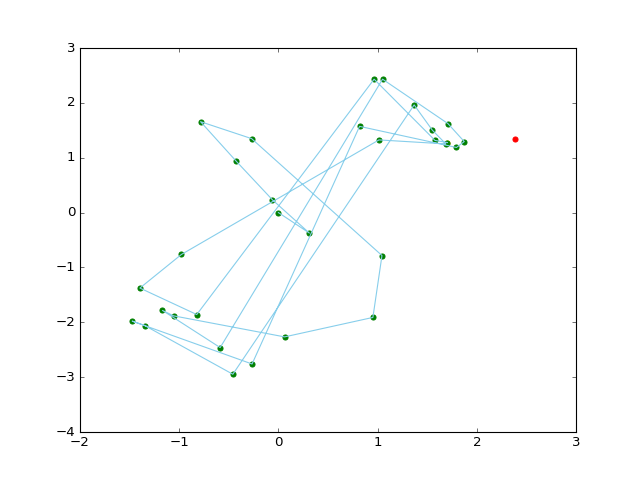

In [58]:
%matplotlib notebook
plt.plot(path[:,0], path[:,1], color='skyblue')
plt.scatter(ref_path[0,0], ref_path[0,1], color='green')
plt.scatter(ref_path[-1,0], ref_path[-1,1], color='red')
plt.scatter(x[:,0], x[:,1], color='orange')
plt.scatter(samples[:,0], samples[:,1], color='green')


<IPython.core.display.Javascript object>


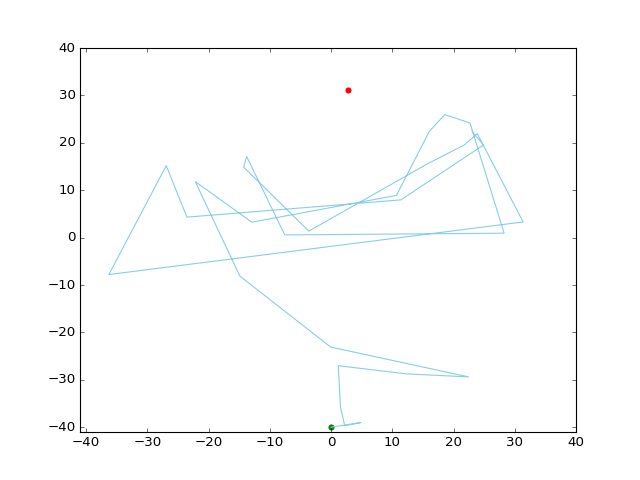

(-41, 40)

In [60]:
%matplotlib notebook
endeff = np.array(endeff)

ex, ey = visualize_point(ref_path[-1])
plt.plot(endeff[:,0], endeff[:,1], color='skyblue')
plt.scatter(endeff[0, 0], endeff[0, 1], color='green')
plt.scatter(ex, ey, color='red')
plt.xlim(-41, 40)
plt.ylim(-41, 40)


In [42]:
endeff

array([[ -1.7444805 , -38.84931598],
       [ -3.0465705 , -36.49443438],
       [ -8.80224626, -38.36277399],
       [ -3.61348917, -29.50472146],
       [  6.29881388, -24.21388936]])